In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("data/stocks_ti.csv")
df2 = pd.read_csv("data/spy.csv").iloc[:,1:]

import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import pickle
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

from ti import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import ConfusionMatrixDisplay


# New datasets

In [56]:
def fill_short_interest_ratio(df):
    """Fill missing short interest ratio values with forward fill"""
    # find columns with short interest ratio
    selected_columns = list(filter(lambda x: "SHORT INTEREST RATIO" in x, df.columns))

    # Forward fill missing values
    df.loc[:, selected_columns] = df.loc[:, selected_columns].ffill()

    return df

In [57]:
def get_log_return(df, lags):
    df['log_ret'] = df['close']
    for lag in lags:
        df[f'lag_ret_{lag}'] = np.log(df['close'] / df['close'].shift(lag))
    return df

In [58]:
df2 = fill_short_interest_ratio(df2)

# lags
lags = [1, 3, 5, 8, 13, 21]

# log returns
df2 = get_log_return(df2, lags)

# set date
df1['date'] = df1['DATE']

# add tis
df2 = pd.concat([df2, pd.concat(technical_indicators(df2), axis=1)], axis=1)

# merge
df = pd.merge(df2, df1[['date','news_sentiment', 'tweet_sentiment']], on='date')

df

,date,close,open,low,high,3m_iv,short_interest_rate,log_ret,lag_ret_1,lag_ret_3,...,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE,news_sentiment,tweet_sentiment
0,2015-01-02,205.43,206.38,204.180,206.88,14.0384,NaN,205.43,-0.000535,-0.015888,...,1.118096,2.700,206.240885,204.589115,21.584724,2.537931,-6.082919,0,0.075776,-0.131934
1,2015-01-05,201.72,204.17,201.350,204.37,14.1676,NaN,201.72,-0.018225,-0.028733,...,1.201799,4.080,205.990390,204.839610,20.649099,1.551261,-3.456028,0,0.116118,-0.102601
2,2015-01-06,199.82,202.09,198.855,202.72,14.3399,NaN,199.82,-0.009464,-0.028224,...,1.264727,3.865,205.780599,205.049401,19.789482,1.107626,-3.389363,0,0.050569,0.025503
3,2015-01-07,202.31,201.42,200.880,202.72,14.4772,NaN,202.31,0.012384,-0.015304,...,1.262324,2.900,205.711936,205.118064,19.052788,-0.081201,-4.809166,0,0.125229,-0.051485
4,2015-01-08,205.90,204.01,203.990,206.16,14.5777,NaN,205.90,0.017589,0.020510,...,1.285281,3.850,205.516848,205.313152,18.432875,-2.143916,-4.606338,0,0.138343,0.100507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2019-12-24,321.23,321.47,320.900,321.52,12.9785,NaN,321.23,0.000031,0.001028,...,0.595781,0.620,315.707815,313.396385,22.355996,4.932280,-2.853776,1,0.238482,-0.048913
1246,2019-12-26,322.94,321.65,321.640,322.95,12.9736,NaN,322.94,0.005309,0.006867,...,0.588339,1.720,316.733905,313.346095,21.679514,3.076909,-3.544026,1,0.277311,0.195297
1247,2019-12-27,322.86,323.74,322.280,323.80,12.9749,NaN,322.86,-0.000248,0.005093,...,0.580078,1.520,317.659182,313.270818,21.213283,2.512045,-2.020154,1,0.249240,0.027661
1248,2019-12-30,321.08,322.95,320.550,323.10,12.9999,NaN,321.08,-0.005528,-0.000467,...,0.598358,2.550,317.590583,313.339417,20.972442,2.004672,-1.863850,1,0.255385,-0.075382


In [61]:
df.isna().sum().sort_values(ascending=False)

short_interest_rate    1131
date                      0
MINUS_DI                  0
TYPPRICE                  0
WCLPRICE                  0
                       ... 
STOCHRSI_D                0
TRIX                      0
ULTOSC                    0
WILLR                     0
tweet_sentiment           0
Length: 66, dtype: int64

In [64]:
df.drop('short_interest_rate', axis=1, inplace=True)

In [86]:
df.set_index('date', inplace=True)

## columns setting

In [87]:
print(df.columns)

Index(['close', 'open', 'low', 'high', '3m_iv', 'log_ret', 'lag_ret_1',
       'lag_ret_3', 'lag_ret_5', 'lag_ret_8', 'lag_ret_13', 'lag_ret_21',
       'ADX', 'APO', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'MACD', 'MACDSIGNAL',
       'MACDHIST', 'MOM', 'RSI', 'STOCH_FASTK', 'STOCH_FASTD', 'STOCHRSI_K',
       'STOCHRSI_D', 'TRIX', 'ULTOSC', 'WILLR', 'SMA', 'EMA', 'WMA', 'DEMA',
       'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'ADX', 'PLUS_DI', 'MINUS_DI', 'SAR',
       'AROON_DOWN', 'AROON_UP', 'AROONOSC', 'WCLPRICE', 'TYPPRICE',
       'MEDPRICE', 'ROC', 'AVGPRICE', 'BBANDS_UPPER', 'BBANDS_MIDDLE',
       'BBANDS_LOWER', 'ATR', 'NATR', 'TRANGE', 'CHANDELIER_EXIT_LONG',
       'CHANDELIER_EXIT_SHORT', 'HT_DCPERIOD', 'HT_PHASOR_inphase',
       'HT_PHASOR_quadrature', 'HT_TRENDMODE', 'news_sentiment',
       'tweet_sentiment'],
      dtype='object')


In [175]:
# only past return and implied vol
X_col1 = ['3m_iv', 'log_ret', 'lag_ret_1','lag_ret_3', 'lag_ret_5', 'lag_ret_8', 'lag_ret_13', 'lag_ret_21']

# + ti
X_col2 = ['3m_iv', 'log_ret', 'lag_ret_1',
       'lag_ret_3', 'lag_ret_5', 'lag_ret_8', 'lag_ret_13', 'lag_ret_21',
       'ADX', 'APO', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'MACD', 'MACDSIGNAL',
       'MACDHIST', 'MOM', 'RSI', 'STOCH_FASTK', 'STOCH_FASTD', 'STOCHRSI_K',
       'STOCHRSI_D', 'TRIX', 'ULTOSC', 'WILLR', 'SMA', 'EMA', 'WMA', 'DEMA',
       'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'ADX', 'PLUS_DI', 'MINUS_DI', 'SAR',
       'AROON_DOWN', 'AROON_UP', 'AROONOSC', 'WCLPRICE', 'TYPPRICE',
       'MEDPRICE', 'ROC', 'AVGPRICE', 'BBANDS_UPPER', 'BBANDS_MIDDLE',
       'BBANDS_LOWER', 'ATR', 'NATR', 'TRANGE', 'CHANDELIER_EXIT_LONG',
       'CHANDELIER_EXIT_SHORT', 'HT_DCPERIOD', 'HT_PHASOR_inphase',
       'HT_PHASOR_quadrature', 'HT_TRENDMODE']

# + sentiment
X_col3 = ['3m_iv', 'log_ret', 'lag_ret_1','lag_ret_3', 'lag_ret_5', 'lag_ret_8', 'lag_ret_13', 'lag_ret_21', 
          'news_sentiment', 'tweet_sentiment']

# + ti + sentiment
X_col4 = ['3m_iv', 'log_ret', 'lag_ret_1',
       'lag_ret_3', 'lag_ret_5', 'lag_ret_8', 'lag_ret_13', 'lag_ret_21',
       'ADX', 'APO', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'MACD', 'MACDSIGNAL',
       'MACDHIST', 'MOM', 'RSI', 'STOCH_FASTK', 'STOCH_FASTD', 'STOCHRSI_K',
       'STOCHRSI_D', 'TRIX', 'ULTOSC', 'WILLR', 'SMA', 'EMA', 'WMA', 'DEMA',
       'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'ADX', 'PLUS_DI', 'MINUS_DI', 'SAR',
       'AROON_DOWN', 'AROON_UP', 'AROONOSC', 'WCLPRICE', 'TYPPRICE',
       'MEDPRICE', 'ROC', 'AVGPRICE', 'BBANDS_UPPER', 'BBANDS_MIDDLE',
       'BBANDS_LOWER', 'ATR', 'NATR', 'TRANGE', 'CHANDELIER_EXIT_LONG',
       'CHANDELIER_EXIT_SHORT', 'HT_DCPERIOD', 'HT_PHASOR_inphase',
       'HT_PHASOR_quadrature', 'HT_TRENDMODE', 'news_sentiment',
       'tweet_sentiment']

X_cols = [X_col1, X_col2, X_col3, X_col4]

In [176]:
df

,close,open,low,high,3m_iv,log_ret,lag_ret_1,lag_ret_3,lag_ret_5,lag_ret_8,...,NATR,TRANGE,CHANDELIER_EXIT_LONG,CHANDELIER_EXIT_SHORT,HT_DCPERIOD,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_TRENDMODE,news_sentiment,tweet_sentiment
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,205.43,206.38,204.180,206.88,14.0384,205.43,-0.000535,-0.015888,-0.011326,-0.005292,...,1.118096,2.700,206.240885,204.589115,21.584724,2.537931,-6.082919,0,0.075776,-0.131934
2015-01-05,201.72,204.17,201.350,204.37,14.1676,201.72,-0.018225,-0.028733,-0.032771,-0.028106,...,1.201799,4.080,205.990390,204.839610,20.649099,1.551261,-3.456028,0,0.116118,-0.102601
2015-01-06,199.82,202.09,198.855,202.72,14.3399,199.82,-0.009464,-0.028224,-0.043577,-0.038918,...,1.264727,3.865,205.780599,205.049401,19.789482,1.107626,-3.389363,0,0.050569,0.025503
2015-01-07,202.31,201.42,200.880,202.72,14.4772,202.31,0.012384,-0.015304,-0.025812,-0.026631,...,1.262324,2.900,205.711936,205.118064,19.052788,-0.081201,-4.809166,0,0.125229,-0.051485
2015-01-08,205.90,204.01,203.990,206.16,14.5777,205.90,0.017589,0.020510,0.001750,-0.012261,...,1.285281,3.850,205.516848,205.313152,18.432875,-2.143916,-4.606338,0,0.138343,0.100507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,321.23,321.47,320.900,321.52,12.9785,321.23,0.000031,0.001028,0.005181,0.012846,...,0.595781,0.620,315.707815,313.396385,22.355996,4.932280,-2.853776,1,0.238482,-0.048913
2019-12-26,322.94,321.65,321.640,322.95,12.9736,322.94,0.005309,0.006867,0.010428,0.017556,...,0.588339,1.720,316.733905,313.346095,21.679514,3.076909,-3.544026,1,0.277311,0.195297
2019-12-27,322.86,323.74,322.280,323.80,12.9749,322.86,-0.000248,0.005093,0.006089,0.010462,...,0.580078,1.520,317.659182,313.270818,21.213283,2.512045,-2.020154,1,0.249240,0.027661


In [177]:
# # double check
# df.isna().sum().sort_values(ascending=False)

In [178]:
# get the split date
test_size = 0.2

split_idx = int(len(df) * (1 - test_size))

print(df.index[split_idx])

2019-01-04


In [179]:
def get_X_y(df, y_size, X_col):
    X = df[:-y_size][X_col]
    y = df[y_size:][f"lag_ret_{y_size}"]
    return X, y


def prep_X_y(df, y_sizes, X_cols):
    col = {}
    for y_size in y_sizes:
        for i, X_col in enumerate(X_cols):
            # get X and y
            X,y = (get_X_y(df, y_size, X_col))

            # for classification
            y_true = y.apply(lambda x: 1 if x > 0 else 0)

            # train_test_split
            X_train = X[:split_idx]
            X_test = X[split_idx:]
            y_train = y_true[:split_idx]
            y_test = y_true[split_idx:]

            # print(X_train.index[-1])

            # standardlize
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            col[(y_size, i)] = (X_train, X_test, y_train.values, y_test.values)

    return col

In [180]:
Xy = prep_X_y(df, lags, X_cols)

In [181]:
Xy.keys()

dict_keys([(1, 0), (1, 1), (1, 2), (1, 3), (3, 0), (3, 1), (3, 2), (3, 3), (5, 0), (5, 1), (5, 2), (5, 3), (8, 0), (8, 1), (8, 2), (8, 3), (13, 0), (13, 1), (13, 2), (13, 3), (21, 0), (21, 1), (21, 2), (21, 3)])

In [182]:
# Xy[(1,0)]

# Modeling

In [233]:
# try gpu

import tensorflow as tf

# Check TensorFlow version to ensure compatibility with GPU
print("TensorFlow version:", tf.__version__)

# List all available devices detected by TensorFlow
available_devices = tf.config.list_physical_devices()
print("Available devices:", available_devices)

# Specifically check for a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("GPU is not available, using CPU instead.")


TensorFlow version: 2.10.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.
1 Physical GPUs, 1 Logical GPUs


In [238]:
# def lstm_classifier(X_train, X_test, y_train, y_test, random_state=257, timesteps=1):
#     """LSTM Classifier with Random Search CV on GPU"""

#     print("LSTM with random search")

#     # Reshape X_train and X_test to be 3D: [samples, timesteps, features]
#     X_train = X_train.reshape((X_train.shape[0], timesteps, -1))
#     X_test = X_test.reshape((X_test.shape[0], timesteps, -1))
#     n_features = X_train.shape[2]  # Number of features per timestep
    

#     def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
#         # Device scope to ensure the model runs on GPU if available
#         with tf.device('/GPU:0'):
#             model = Sequential([
#                 LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
#                 Dropout(dropout_rate),
#                 LSTM(units),
#                 Dropout(dropout_rate),
#                 Dense(1, activation='sigmoid')
#             ])
#             model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#         return model

#     # Set up the parameter grid to sample from during fitting
#     param_distributions = {
#         'units': np.arange(20, 100, 10),
#         'dropout_rate': np.linspace(0.1, 0.5, 5),
#         'optimizer': ['adam', 'rmsprop'],
#         'batch_size': [16, 32, 64],
#         'epochs': [10, 20, 30]
#     }

#     # Create and wrap the model with KerasClassifier
#     model = KerasClassifier(build_fn=create_model, verbose=0)

#     # Create the random search with CV object
#     random_search = RandomizedSearchCV(
#         estimator=model,
#         param_distributions=param_distributions,
#         n_iter=20,  # Number of parameter settings sampled
#         scoring='accuracy',  # Metric for evaluation
#         cv=3,  # 3-fold cross-validation
#         verbose=1,  # Control the verbosity level
#         random_state=random_state,
#         n_jobs=1  # Ensure TensorFlow compatibility
#     )

#     # Fit the random search model
#     random_search.fit(X_train, y_train)

#     # Best model found by random search
#     best_model = random_search.best_estimator_.model

#     # Predict on test data using the best model
#     y_prob = best_model.predict(X_test).flatten()
#     y_pred = (y_prob > 0.5).astype('int32')

#     # Evaluate the best model
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Accuracy: {accuracy:.5f}")
#     cm = confusion_matrix(y_test, y_pred)

#     return y_pred, cm, best_model, (y_test, y_prob)

In [231]:
def logistic_regression(X_train, X_test, y_train, y_test, random_state=257):
    """Logistic Regression"""
    print("logistics regression")
    # train model
    clf = LogisticRegression(random_state=random_state)
    clf.fit(X_train, y_train)

    # predict on test data
    y_pred = clf.predict(X_test)

    # evaluate model
    print(f"Accuracy: {accuracy_score(y_test, y_pred) :.5f}")
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return y_pred, cm, clf, (y_test, clf.predict_proba(X_test)[:, 1])


def random_forest_classifier(X_train, X_test, y_train, y_test):
    """Random Forest Classifier with Random Search CV"""

    print("random forest with random search")

    # Define the model
    clf = RandomForestClassifier(random_state=257)

    # Set up the parameter grid to sample from during fitting
    param_distributions = {
        "n_estimators": np.arange(100, 1100, 100),
        "max_depth": [None] + list(np.arange(10, 110, 10)),
        "min_samples_split": np.arange(2, 21),
        "min_samples_leaf": np.arange(1, 21),
        # "max_features": ["auto", "sqrt", "log2"],
    }

    # Create the random search with CV object
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=100,  # Number of parameter settings sampled
        scoring="accuracy",  # Can be changed to other metrics
        cv=3,  # 3-fold cross-validation
        verbose=1,  # Higher the number, more the verbosity
        random_state=257,
        n_jobs=-1,  # Use all available cores
    )

    # Fit the random search model
    random_search.fit(X_train, y_train)

    # Best model found by random search
    best_clf = random_search.best_estimator_

    # Predict on test data using the best model
    y_pred = best_clf.predict(X_test)

    # Evaluate the best model
    print(f"Accuracy: {accuracy_score(y_test, y_pred) :.5f}")
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # # Print best model parameters
    # print("Best model parameters:", random_search.best_params_)

    return y_pred, cm, best_clf, (y_test, best_clf.predict_proba(X_test)[:, 1])

def xgboost_classifier(X_train, X_test, y_train, y_test, random_state=257):
    """XGBoost Classifier with Random Search CV"""

    print("XGBoost with random search")

    # Define the classifier
    clf = XGBClassifier(random_state=random_state)

    # Set up the parameter grid to sample from during fitting
    param_distributions = {
        "n_estimators": np.arange(50, 400, 50),
        "max_depth": np.arange(3, 15, 1),
        "learning_rate": np.linspace(0.01, 0.3, 30),
        "subsample": np.linspace(0.7, 1, 30),
        "colsample_bytree": np.linspace(0.5, 1, 30),
        "min_child_weight": np.arange(1, 10, 1),
    }

    # Create the random search with CV object
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=100,  # Number of parameter settings sampled
        scoring="accuracy",  # Can be changed to other metrics
        cv=3,  # 5-fold cross-validation
        verbose=1,  # Higher the number, more the verbosity
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
    )

    # Fit the random search model
    random_search.fit(X_train, y_train)

    # Best model found by random search
    best_clf = random_search.best_estimator_

    # Predict on test data using the best model
    y_pred = best_clf.predict(X_test)

    # Evaluate the best model
    print(f"Accuracy: {accuracy_score(y_test, y_pred) :.5f}")
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # # Print best model parameters
    # print("Best model parameters:", random_search.best_params_)

    return y_pred, cm, best_clf, (y_test, best_clf.predict_proba(X_test)[:, 1])

# LSTM



In [232]:
Xy.keys()

dict_keys([(1, 0), (1, 1), (1, 2), (1, 3), (3, 0), (3, 1), (3, 2), (3, 3), (5, 0), (5, 1), (5, 2), (5, 3), (8, 0), (8, 1), (8, 2), (8, 3), (13, 0), (13, 1), (13, 2), (13, 3), (21, 0), (21, 1), (21, 2), (21, 3)])

In [188]:
# match keys
def map_keys(key):
    predict_window = str(key[0])
    if key[1] == 0:
        using = 'only return'
    elif key[1] == 1:
        using = 'return and technical indicators'
    elif key[1] == 2:
        using = 'return and sentiment'
    elif key[1] == 3:
        using = 'all'
    return predict_window, using

In [201]:
def run_all(train_test_data):
    # Store results in a nested dictionary
    all_results = {}

    for key, (X_train, X_test, y_train, y_test) in train_test_data.items():
        predict_window, using = map_keys(key)

        # Initialize nested dictionaries if not already present
        if predict_window not in all_results:
            all_results[predict_window] = {}
        if using not in all_results[predict_window]:
            all_results[predict_window][using] = {}

        print("-"*20)
        print(f"Predicting {predict_window} day return, using {using}")

        # Store results for each method in the appropriately nested dictionary
        all_results[predict_window][using]["Logistics"] = logistic_regression(X_train, X_test, y_train, y_test)
        all_results[predict_window][using]["Random Forest"] = random_forest_classifier(X_train, X_test, y_train, y_test)
        all_results[predict_window][using]["XGBoost"] = xgboost_classifier(X_train, X_test, y_train, y_test)

    return all_results


In [203]:
all_results = run_all(Xy)

--------------------
Predicting 1 day return, using only return
logistics regression
Accuracy: 0.48594
random forest with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.44980
XGBoost with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.50201
--------------------
Predicting 1 day return, using return and technical indicators
logistics regression
Accuracy: 0.40161
random forest with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.41767
XGBoost with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.40964
--------------------
Predicting 1 day return, using return and sentiment
logistics regression
Accuracy: 0.46185
random forest with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.45783
XGBoost with random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 0.48

In [227]:
# # check all results
# all_results

In [239]:
import pickle

with open("new_results.pkl", "wb") as file:
    pickle.dump(all_results, file)

## Load results

In [3]:
with open("new_results.pkl", "rb") as file:
    all_results = pickle.load(file)

## Summary table

| Prediction Window | Feature Type                            | Logistic Regression | Random Forest | XGBoost |
|-------------------|-----------------------------------------|---------------------|---------------|---------|
| 1 day             | Only Return                             | *0.48594*             | 0.44980       | **0.50201** |
| 1 day             | Return and Technical Indicators         | 0.40161             | 0.41767       | 0.40964 |
| 1 day             | Return and Sentiment                    | 0.46185             | 0.45783       | 0.48996 |
| 1 day             | All                                     | 0.40964             | 0.41767       | 0.40964 |
| 3 days            | Only Return                             | **0.51822**             | 0.45749       | 0.39676 |
| 3 days            | Return and Technical Indicators         | 0.36032             | 0.37652       | 0.39676 |
| 3 days            | Return and Sentiment                    | 0.47773             | 0.41296       | 0.41296 |
| 3 days            | All                                     | 0.34818             | 0.37247       | 0.37247 |
| 5 days            | Only Return                             | 0.48163             | 0.45306       | 0.40408 |
| 5 days            | Return and Technical Indicators         | 0.36327             | 0.48163       | 0.39592 |
| 5 days            | Return and Sentiment                    | 0.48163             | 0.40816       | 0.36327 |
| 5 days            | All                                     | 0.36735             | 0.44898       | 0.36327 |
| 8 days            | Only Return                             | 0.57851             | 0.44215       | 0.38843 |
| 8 days            | Return and Technical Indicators         | 0.30165             | 0.43388       | 0.38843 |
| 8 days            | Return and Sentiment                    | **0.58264**             | 0.41736       | 0.36777 |
| 8 days            | All                                     | 0.30579             | 0.42149       | 0.40496 |
| 13 days           | Only Return                             | 0.70464             | 0.46835       | 0.32911 |
| 13 days           | Return and Technical Indicators         | 0.51055             | 0.45992       | 0.52321 |
| 13 days           | Return and Sentiment                    | **0.72152**             | 0.45570       | 0.39241 |
| 13 days           | All                                     | 0.49789             | 0.41772       | 0.52743 |
| 21 days           | Only Return                             | **0.73799**             | 0.40175       | 0.42795 |
| 21 days           | Return and Technical Indicators         | 0.52838             | 0.48035       | 0.50655 |
| 21 days           | Return and Sentiment                    | 0.68122             | 0.41048       | 0.45415 |
| 21 days           | All                                     | 0.51528             | 0.47598       | 0.52838 |


## Confucsion Matrix

In [11]:
def plot_all_confusion_matrices(all_results):
    num_feature_types =  sum(len(v) for v in all_results.values())
    num_classifiers = 3  # 3 classifiers: Logistic, Random Forest, XGBoost

    # Create subplot grid
    fig, axes = plt.subplots(num_feature_types, num_classifiers, figsize=(15, num_feature_types * 4))  # Adjust subplot grid if needed

    row = 0
    for predict_window, using_dict in all_results.items():
        for using, classifiers in using_dict.items():
            col = 0
            for classifier, result in classifiers.items():
                cm = result[1] 
                disp = ConfusionMatrixDisplay(
                    confusion_matrix=cm,
                    display_labels=["down", "up"]  # Assuming binary classification: down/up
                )
                disp.plot(ax=axes[row, col], cmap="Blues", values_format=".0f", colorbar=False)
                axes[row, col].set_title(
                    f"{predict_window} days, {using}, using {classifier}",
                    fontsize=10
                )
                col += 1
            row += 1

    # Adjust layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



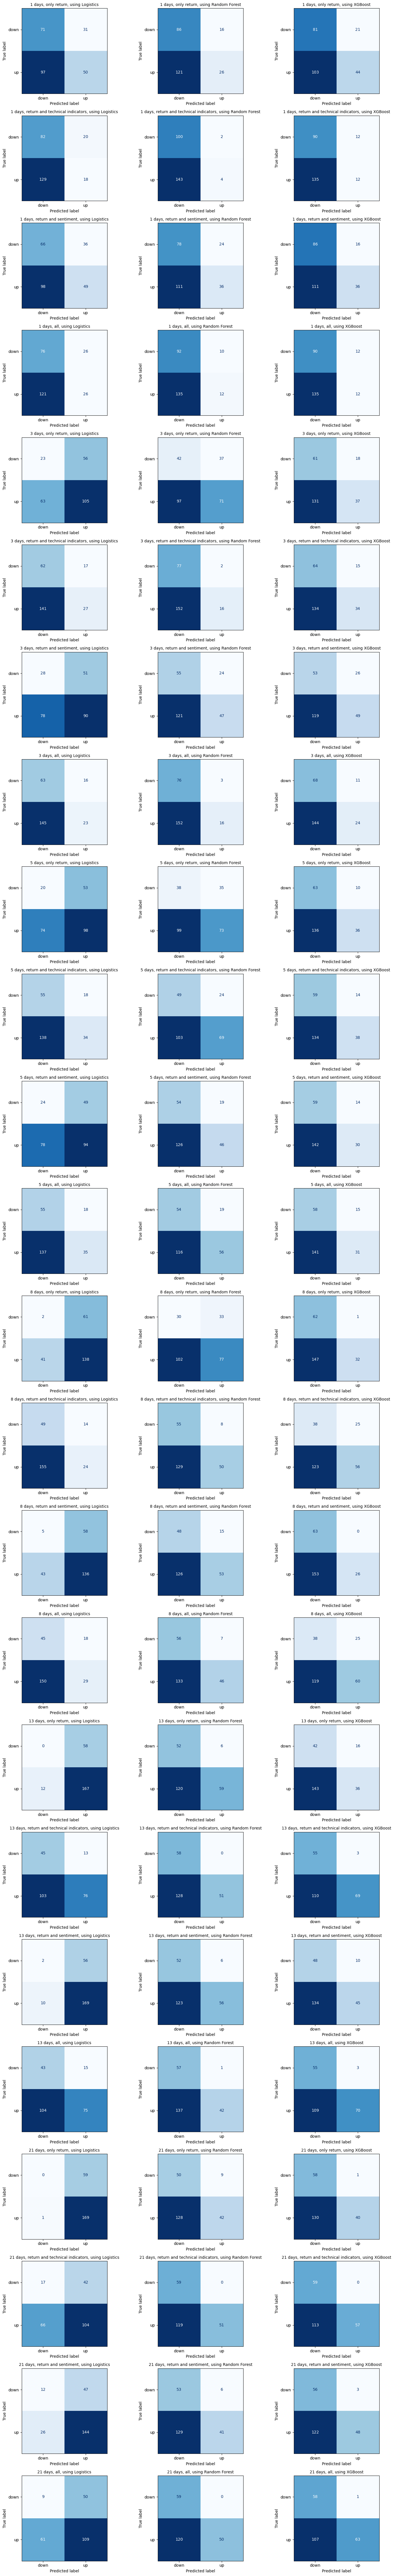

In [12]:
plot_all_confusion_matrices(all_results)

## ROC AUC

In [225]:
def plot_all_roc(all_results):
    # Calculate the number of rows needed in the subplot grid
    num_feature_types = sum(len(v) for v in all_results.values())
    num_classifiers = 3  # Logistic, Random Forest, XGBoost
    
    # Create a subplot grid of appropriate size
    fig, axes = plt.subplots(num_feature_types, num_classifiers, figsize=(20, 80), squeeze=False)
    # fig.suptitle(title, fontsize=16)

    row = 0
    for predict_window, using_dict in all_results.items():
        for using, classifiers in using_dict.items():
            col = 0
            for classifier, results in classifiers.items():
                y_test, y_prob = results[-1][0], results[-1][1]
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                
                axes[row, col].plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
                axes[row, col].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
                axes[row, col].set_xlim([0.0, 1.0])
                axes[row, col].set_ylim([0.0, 1.05])
                axes[row, col].legend(loc="lower right")
                
                axes[row, col].set_title(f"{predict_window} days: {using} using {classifier}", fontsize=10)
                col += 1
            row += 1

    # Adjust layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


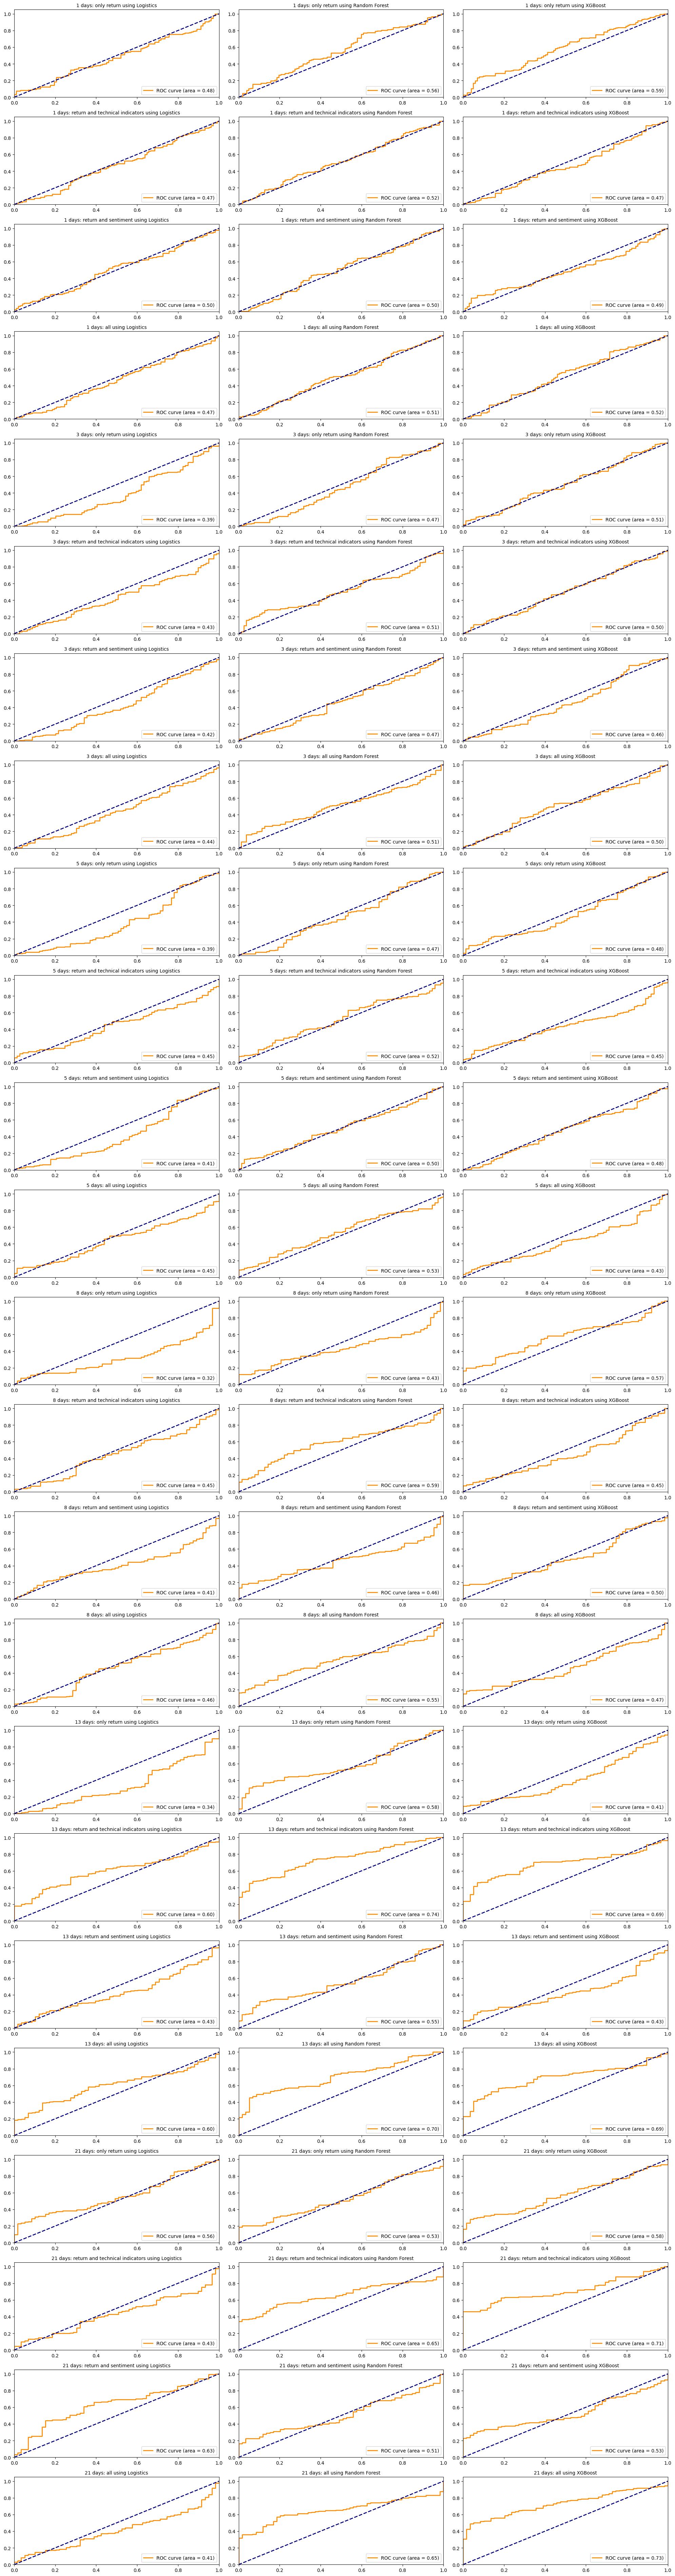

In [226]:
plot_all_roc(all_results)